In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [3]:
stack_idx = 'ew'
models = '8,10,13,18,19,22,24,27'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[8, 10, 13, 18, 19, 22, 24, 27]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
10 model-10-lgb-feats-selection-75-lr-0.001-cv.csv
10 model-10-lgb-feats-selection-75-lr-0.001-test-kfold.csv
10 model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
13 model-13-predict-keras-he_uni-cv.csv
13 model-13-predict-keras-he_uni-test-kfold.csv
13 model-13-predict-keras-he_uni-test-one.csv
18 model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
18 model-18-lgb-feats-selection-70-lr-0.001-p5-test-kfold.csv
18 model-18-lgb-feats-selection-70-lr-0.001-p5-test-one.csv
19 model-19-lgb-search-bins-lr-0.0005-cv.csv
19 model-19-lgb-search-bins-lr-0.0005-test-kfold.csv
19 model-19-lgb-search-bins-lr-0.0005-test-one.csv
22 model-22-lgb-wo-per-area-long-2-cv.csv
22 model-22-lgb-wo-per-area-long-2-test-kfold.csv
22 model-22-lgb-wo-per-area-long-2-test-one.csv
24 model-24-lgb-binary-augment-cv.csv
24 model-24-lgb-binary-augment-test-kfold.csv
24 model-24-lgb-binary-au

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
8
model-08-keras-search-long-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-24-lgb-binary-augment-cv.csv
model-27-lgb-feat_rm_new-cv.csv


In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-08-keras-search-long-test-kfold.csv
No. 1 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 2 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 3 file: model-18-lgb-feats-selection-70-lr-0.001-p5-test-one.csv
No. 4 file: model-19-lgb-search-bins-lr-0.0005-test-one.csv
No. 5 file: model-22-lgb-wo-per-area-long-2-test-one.csv
No. 6 file: model-24-lgb-binary-augment-test-one.csv
No. 7 file: model-27-lgb-feat_rm_new-test-one.csv


In [12]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_8,log_pred_8,log_parea_pred_8,pred_10,log_pred_10,log_parea_pred_10,pred_13,...,log_pred_22,log_parea_pred_22,pred_24,log_pred_24,log_parea_pred_24,pred_27,log_pred_27,log_parea_pred_27,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,725253.9,13.494278,12.265175,6.666997e+05,13.410097,12.180993,633171.2,...,13.451562,12.222459,6.305493e+05,13.354348,12.125245,6.477905e+05,13.381324,12.152221,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,2841281.8,14.859766,13.463199,3.161088e+06,14.966427,13.569860,3101206.5,...,14.956756,13.560188,3.058136e+06,14.933317,13.536749,3.127411e+06,14.955716,13.559149,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9507449.0,16.067586,14.347631,9.737051e+06,16.091449,14.371494,9499881.0,...,16.109236,14.389281,9.860001e+06,16.103997,14.384042,9.745913e+06,16.092359,14.372404,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,12914970.0,16.373898,13.766551,1.269176e+07,16.356463,13.749117,12871026.0,...,16.364881,13.757534,1.276711e+07,16.362383,13.755036,1.259548e+07,16.348848,13.741502,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1351634.2,14.116826,12.571799,1.122204e+06,13.930806,12.385780,1657203.4,...,14.030033,12.485007,1.113243e+06,13.922789,12.377763,1.131428e+06,13.938992,12.393966,13.544637,11.999613


,building_id,building_area,pred_8,log_pred_8,log_parea_pred_8,pred_10,log_pred_10,log_parea_pred_10,pred_13,log_pred_13,...,log_parea_pred_19,pred_22,log_pred_22,log_parea_pred_22,pred_24,log_pred_24,log_parea_pred_24,pred_27,log_pred_27,log_parea_pred_27
0,X5gsdTWGS3W7JJQB,3.418175,12899050.0,16.372664,15.143558,1.427889e+07,16.474293,15.245186,12507661.0,16.341852,...,15.245864,1.201060e+07,16.301300,15.072193,1.351205e+07,16.419093,15.189986,1.405424e+07,16.458435,15.229328
1,BTshNOJyKHnT2YIT,7.726227,3933929.2,15.185150,13.140531,3.920610e+06,15.181758,13.137139,3950855.8,15.189443,...,13.134906,3.933533e+06,15.185049,13.140430,3.933543e+06,15.185051,13.140432,3.932854e+06,15.184876,13.140257
2,dhdymr0lV8N5kZOT,12.170581,11718318.0,16.276664,13.777643,1.067153e+07,16.183090,13.684070,11867083.0,16.289279,...,13.686933,1.146014e+07,16.254386,13.755365,1.024997e+07,16.142786,13.643765,1.040041e+07,16.157355,13.658335
3,VEwyGGMcD56w5BOc,2.252256,5997081.0,15.606784,14.794851,6.082243e+06,15.620884,14.808952,5886018.5,15.588091,...,14.796868,5.778982e+06,15.569738,14.757806,5.898278e+06,15.590171,14.778239,5.905111e+06,15.591329,14.779397
4,wmUeMoJZfsqaSX9b,5.813985,1074525.1,13.887390,12.127129,1.059463e+06,13.873273,12.113012,1085330.8,13.897396,...,12.138313,9.995482e+05,13.815060,12.054798,1.142096e+06,13.948376,12.188114,1.048505e+06,13.862877,12.102615


### Check models scores

In [13]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-08 5514.858826
 1 model-10 5897.873845
 2 model-13 5506.858055
 3 model-18 5908.874297
 4 model-19 5911.874156
 5 model-22 5752.870671
 6 model-24 5866.873835
 7 model-27 5892.873194


In [14]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [15]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        print('find better score:')
        print('score: ', score)
        print('coeffs: ', x)
        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [16]:
best_score = {}
best_coeffs = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

for metric in ['mape']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(metric), tol=1e-4)

Optimizing with init x0: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]

find better score:
score:  4.2543606882936755
coeffs:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]

find better score:
score:  4.254360738890983
coeffs:  [0.11111113 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]

find better score:
score:  139.58461830186516
coeffs:  [0.11895224 0.11895173 0.11895158 0.11895181 0.11895182 0.11895179
 0.11895169 0.11895169 0.11169588]

find better score:
score:  139.58461841479712
coeffs:  [0.11895225 0.11895173 0.11895158 0.11895181 0.11895182 0.11895179
 0.11895169 0.11895169 0.11169588]

find better score:
score:  2423.781425048323
coeffs:  [0.12537028 0.12536937 0.12536908 0.12536951 0.12536952 0.12536947
 0.12536929 0.12536928 0.11217452]

find 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.4810220451423805, 0.47000149155950555, 0.20808148340662824, 1.6139199623274152, -0.28958379384262023, -1.067275553142491, 1.6802378941569467, -0.2524135149035508, 0.727677538942908]



In [17]:
display(best_score)
display(best_coeffs)

{'mape': 5964.87654464238}

{'mape': array([ 0.10823691,  0.11276671,  0.07002347,  0.13022661,  0.12272676,
         0.1554293 ,  0.17636585,  0.13341075, -0.13582172])}

### Compute submission

In [18]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}.csv'.format(stack_idx, models), index=False)

### Plots

In [19]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


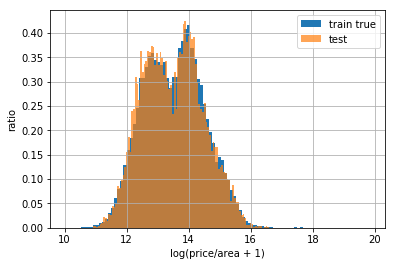

In [20]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

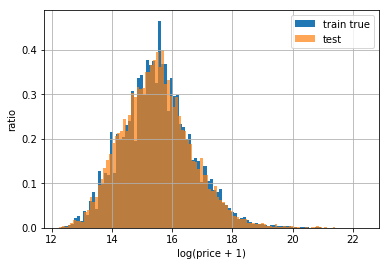

In [21]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

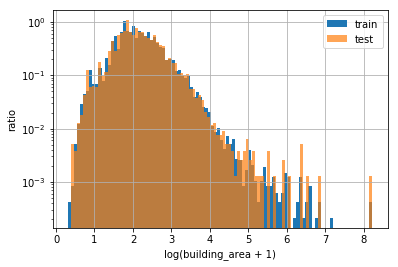

In [22]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [23]:
print([1/17 if i in [3, 4, 7, 8, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26] else 0 \
 for i in list(range(1,24)) + list(range(25,28))])

[0, 0, 0.058823529411764705, 0.058823529411764705, 0, 0, 0.058823529411764705, 0.058823529411764705, 0, 0, 0, 0.058823529411764705, 0.058823529411764705, 0, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0]
